In [104]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# # Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# # Correct paths to the train and test directories
# train_dir = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/train/"
# test_dir = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/test/"

# # Data transformations
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),  # Resize images to 224x224
#     transforms.ToTensor(),         # Convert images to tensors
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
# ])

# # Load datasets
# train_data = datasets.ImageFolder(root=train_dir, transform=transform)
# test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# # Data loaders
# train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

# Class names and mapping
# print(f"Classes: {train_data.classes}")
# print(f"Class-to-index mapping: {train_data.class_to_idx}")

Using device: cuda


In [105]:
# # Load pretrained ResNet50 model
# model = models.resnet50(pretrained=True)

# # Modify the last fully connected layer to match the number of classes in your dataset
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(train_data.classes))  # Adjust for the number of classes

# # Move model to GPU if available
# model = model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)""

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     # Iterate over training data
#     for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()  # Zero the gradients
#         outputs = model(inputs)  # Forward pass
#         loss = criterion(outputs, labels)  # Calculate loss
#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update weights
        
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
    
#     epoch_loss = running_loss / len(train_loader)
#     epoch_acc = correct / total
#     print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")
    
#     # Validation loop
#     model.eval()  # Set model to evaluation mode
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0
    
#     with torch.no_grad():  # No need to track gradients for validation
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
            
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_loss = val_loss / len(test_loader)
#     val_acc = val_correct / val_total
#     print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# # Save the trained model
# torch.save(model.state_dict(), 'resnet50_dog_model.pth')

In [106]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import torch.nn as nn
import torch.optim as optim

# Define Gaussian blur function
def gaussian_blur(image, ksize=3):
    return cv2.GaussianBlur(image, (ksize, ksize), 2.7, 9)

# Define the custom Dataset for blurred images
class BlurredDogDataset(Dataset):
    def __init__(self, dataset, blur_ksize=3):
        self.dataset = dataset
        self.blur_ksize = blur_ksize

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image, label = self.dataset[idx]
        original_image_np = np.array(original_image)  # Convert to numpy array
  
        # Apply Gaussian blur
        blurred_image_np = gaussian_blur(original_image_np, self.blur_ksize)
       
        # Add Gaussian noise
        gaussian_noise = 0.1 * np.random.randn(*blurred_image_np.shape)
        blurred_image_np += gaussian_noise
        # gaussian_noise = 0.2 * np.random.randn(*blurred_image_np.shape)
        # blurred_image_np += gaussian_noise
        # Convert back to tensors (ensure they are in the (C, H, W) format)
        blurred_image = torch.tensor(blurred_image_np).float()  # Convert to tensor
        original_image = torch.tensor(original_image_np).float()  # Convert to tensor
        
        # Ensure the images are in the (C, H, W) format (channels first)
        blurred_image = blurred_image.permute(0, 1,2)  # Convert to (C, H, W)
        original_image = original_image.permute(0, 1, 2)  # Convert to (C, H, W)
        # Return original, blurred images, and the label
        return original_image, blurred_image, label

# Data transformations for the Stanford Dogs Dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the Stanford Dogs Dataset
train_data = datasets.ImageFolder(root='/kaggle/input/stanford-dogs-dataset-traintest/cropped/train/', transform=transform)
test_data = datasets.ImageFolder(root='/kaggle/input/stanford-dogs-dataset-traintest/cropped/test/', transform=transform)

In [107]:
# Define the number of samples you want for training and testing
num_train_samples = 30
num_test_samples = 500

# Generate random indices for the training subset
train_indices = torch.randperm(len(train_data)).tolist()[:num_train_samples]
train_subset = torch.utils.data.Subset(train_data, train_indices)

# Generate random indices for the testing subset
test_indices = torch.randperm(len(test_data)).tolist()[:num_test_samples]
test_subset = torch.utils.data.Subset(test_data, test_indices)

# Create DataLoaders for the normal train/test sets
train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

# Now create the blurred versions of these subsets using BlurredDogDataset
blurred_train_dataset = BlurredDogDataset(train_subset)
blurred_test_dataset = BlurredDogDataset(test_subset)

# Create DataLoaders for the blurred datasets
blurred_train_loader = DataLoader(blurred_train_dataset, batch_size=1, shuffle=True)
blurred_test_loader = DataLoader(blurred_test_dataset, batch_size=1, shuffle=False)

In [108]:
model = models.resnet50(pretrained=False) 
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_data.classes))  # Adjust for the number of classes
model.load_state_dict(torch.load('/kaggle/input/stanford_dogs_resnet50/pytorch/default/1/resnet50_dog_model.pth'))
model = model.to(device)

/tmp/ipykernel_105/910992481.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/stanford_dogs_resnet50/pytorch/default/1/res

In [109]:
# Evaluate on test set and calculate accuracy score
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate and print accuracy using sklearn's accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4680


In [110]:
# Evaluate on test set and calculate accuracy score
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

with torch.no_grad():
    for _,inputs, labels in blurred_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate and print accuracy using sklearn's accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.1520


In [111]:
# import matplotlib.pyplot as plt

# # Denormalize function
# def denormalize(tensor, mean, std):
#     # Denormalize each channel (C, H, W)
#     for c in range(tensor.shape[1]):  # Loop over channels (C)
#         tensor[:, c] = tensor[:, c] * std[c] + mean[c]
#     return tensor

# # Function to plot 5 images in a batch
# def plot_images(batch, num_images=5):
#     # Unpack the batch
#     original_images, blurred_images, labels = batch
    
#     # Denormalize the images
#     mean = torch.tensor([0.485, 0.456, 0.406])
#     std = torch.tensor([0.229, 0.224, 0.225])
    
#     # Denormalize the blurred images (batch of images)
#     blurred_images = denormalize(blurred_images.clone(), mean, std)
    
#     # Create a figure to hold the images
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
#     # Plot each image in the batch
#     for i in range(num_images):
#         ax = axes[i]
#         ax.imshow(blurred_images[i].permute(1, 2, 0).numpy())  # Convert (C, H, W) to (H, W, C)
#         ax.axis('off')
#         ax.set_title(f"Label: {labels[i].item()}")
    
#     plt.show()

# # Fetch a batch of images from the blurred_train_loader and plot them
# for batch in blurred_train_loader:
#     plot_images(batch, num_images=2)
#     break  # Just plot one batch

# **HOAG**

In [119]:
def conjugate_gradient(H, b, tol=1e-6, max_iter=100): #used to solve Hx = b, where H is function 
                                                      #that calculates Hx.
    x = torch.zeros_like(b)
    r = b.clone()
    p = r.clone()
    rsold = torch.sum(r*r)

    for i in range(max_iter):
        Hp = H(p)
        alpha = rsold / torch.sum(p* Hp)
        x = x + alpha * p
        r = r - alpha * Hp
        rsnew = torch.sum(r*r)

        if torch.sqrt(rsnew) < tol:
            break

        p = r + (rsnew / rsold) * p
        rsold = rsnew

    return x

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

# Smoothed Total Variation Function
def Smoothed_TV(x, theta):
    batch_size = x.size(0)
    diff_x = x[:, :, :, 1:] - x[:, :, :, :-1]
    diff_x = F.pad(diff_x, (0, 1), mode='constant', value=0)
    diff_y = x[:, :, 1:, :] - x[:, :, :-1, :]
    diff_y = F.pad(diff_y, (0, 0, 0, 1), mode='constant', value=0)
    norm_grad = torch.sqrt(diff_x.pow(2) + diff_y.pow(2) + torch.exp(theta[1])**2)
    regularizer = torch.exp(theta[0]) * norm_grad.view(batch_size, -1).mean()
    return regularizer

In [120]:
class RegularizerScaler(torch.nn.Module):
    def __init__(self, regu, initial_alpha=10**-5, kernel_size=7, num_kernels=10):
        super(RegularizerScaler, self).__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(initial_alpha))
        self.kernel_size = kernel_size
        self.num_kernels = num_kernels
        self.regu = regu

    def forward(self, noisy_x, lambda0):
        if self.regu == "smoothed_tv":
            regularizer = Smoothed_TV(noisy_x, lambda0)
        elif self.regu == "FoE":
            regularizer = (10**-2)*foe_regularizer(noisy_x, lambda0, kernel_size=self.kernel_size, num_kernels=self.num_kernels)
        return regularizer

In [121]:
def inner_loss(noisy_x, x_star, lambda0, regularizer):
    residual = noisy_x - x_star
    loss = torch.mean(residual**2)
    regularizer_term = regularizer.forward(noisy_x, lambda0)
    return loss + regularizer_term

def inner_optimization(noisy_x, lambda0, x_star,regularizer,tol=1e-1, max_iter=100):
    recons_x = noisy_x.requires_grad_(True)
    
    # Include the parameters of the regularizer (i.e., alpha) in the optimizer
    optimizer = optim.LBFGS([recons_x] + list(regularizer.parameters()), lr=1e-1, max_iter=max_iter, tolerance_grad=tol, tolerance_change=tol)

    def closure():
        optimizer.zero_grad()
        loss = inner_loss(noisy_x, x_star,lambda0,regularizer=regularizer).to(noisy_x.device)
        loss.backward(retain_graph= True)
        return loss

    for _ in range(max_iter):
        optimizer.step(closure)

    return recons_x

In [122]:
def compute_Hv(loss, p, u, v, flag="both"): 
    """
    Compute the Hessian-vector product and the gradient.
    
    Parameters:
    - loss: Precomputed scalar loss.
    - p: The vector to multiply with the Hessian.
    - u: Tensor with respect to which the first derivative is taken.
    - v: Tensor with respect to which the Hessian is calculated.
    - flag: Specifies what to return ("grad", "both", "hess").
    
    Returns:
    - Depending on the flag, returns:
      - "grad": Gradient of the loss with respect to u.
      - "both": Gradient of the loss with respect to u and the Hessian-vector product.
      - "hess": Hessian-vector product only.
    """
    grad_u = autograd.grad(loss, u, create_graph=True)[0]
    
    if flag == "grad":
        return grad_u
    
    elif flag == "both":
        dell_u_times_p = torch.sum(grad_u * p)
        Hv = autograd.grad(dell_u_times_p, v, retain_graph=True)[0]
        return grad_u, Hv
    
    elif flag == "hess":
        dell_u_times_p = torch.sum(grad_u * p)
        Hv = autograd.grad(dell_u_times_p, v, retain_graph=True)[0]
        return Hv

def create_H_function(loss, u, v):
    """
    Creates a function H(p) that computes the Hessian-vector product for a given vector p.
    
    Parameters:
    - loss: Precomputed scalar loss.
    - u: Tensor with respect to which the first derivative is taken.
    - v: Tensor with respect to which the Hessian is calculated.
    
    Returns:
    - A function H(p) that computes the Hessian-vector product Hv.
    """
    def H(p):
        return compute_Hv(loss, p, u, v, flag="hess")
    
    return H

In [123]:
def hoag_algorithm(noisy_x, lambda0, x_star, labels, regu, 
                   T_star, device, max_iter=20, k=1.0, 
                   epsilon=1e-8,kernel_size=5,num_kernels=2):
    
    lambda0 = lambda0.to(device)
    tol = 0.0001  # Initial tolerance

    # Initialize RegularizerScaler
    regularizer = RegularizerScaler(regu = regu, kernel_size=kernel_size, num_kernels=num_kernels).to(device)
    # Step (i): Solve the inner optimization problem to get the initial gradient
    recons_x = inner_optimization(noisy_x, lambda0, x_star,regularizer=regularizer, 
                                  tol=tol).to(device)
    output = T_star(recons_x)
    criterion = torch.nn.CrossEntropyLoss()
    outer_loss = criterion(output, labels).to(device)
    grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)
    
    # Compute the initial p1 (approximate gradient) and initialize L
    p1 = torch.linalg.matrix_norm(grad_g_x).mean().item()
    L = k * p1
#     print(L)

    for iteration in range(max_iter):
        # Apply exponential decay to tol
        tol = max(tol * (1 - iteration / max_iter)**5, epsilon)  # Ensure tol does not go below epsilon

        # Step (i): Solve the inner optimization problem
        recons_x = inner_optimization(noisy_x, lambda0, x_star, 
                                      regularizer=regularizer, tol=tol).to(device)
        
        # Compute the outer loss based on recons_x
        output = T_star(recons_x)
        outer_loss = criterion(output, labels).to(device)
        
        # Compute the gradient with respect to recons_x
        grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)        
        
        # Step (ii): Compute the Hessian-vector product
        new_inner_loss = inner_loss(noisy_x, x_star, lambda0, regularizer).to(device)
        Hxx = create_H_function(new_inner_loss, recons_x, recons_x)
        q_k = conjugate_gradient(Hxx, grad_g_x, tol=tol, max_iter=max_iter)
        hxlambda = compute_Hv(new_inner_loss, q_k, recons_x, lambda0, flag="hess").to(device)
        p_k = -hxlambda
        noisy_x = recons_x

    return p_k, L, outer_loss,regularizer

In [124]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Smoothed_tv**

In [125]:
import time
import copy
from tqdm import tqdm  # Import tqdm for progress bars
import torch
import torch.optim as optim

# Initialize lambda0
# Initialize lambda0 as a leaf tensor with values of 4
lambda0 = 3*torch.ones(2, requires_grad=True, device=device)  # Initialize tensor with value 3
regu = "smoothed_tv"
saved_images = []

# Loss function
criterion = torch.nn.CrossEntropyLoss()
T_star = model

for epoch in range(1):  # Adjust epochs as needed
    # Training Phase
    train_start_time = time.time()

    # Initialize the accumulated gradient
    accumulated_grad = torch.zeros_like(lambda0).to(device)

    # Add tqdm for the training loop
    train_loader = tqdm(blurred_train_loader, desc=f"Training Epoch {epoch + 1}")
    total_train_loss = 0.0
    total_samples = 0

    for batch_idx, (gt, noisy, labels) in enumerate(train_loader):
        gt, noisy, labels = gt.to(device), noisy.to(device), labels.to(device)

        # Apply HOAG algorithm (inner optimization)
        pk, L, loss, regularizer = hoag_algorithm(
            noisy_x=noisy, lambda0=lambda0, x_star=gt,
            labels=labels, regu=regu,
            T_star=T_star, device=device, max_iter=3, k=1.0,
            epsilon=1e-4, kernel_size=5, num_kernels=2)

        # Update lambda0
        L = 1 / L
        lambda0 = lambda0 - L * pk

        # Clamp lambda0 to the desired range after the update
        lambda0.data = lambda0.data.clamp(min=-10, max=4)

        # Track total loss and samples for average loss computation
        total_train_loss += loss.item() * labels.size(0)  # Multiply by batch size
        total_samples += labels.size(0)

        # Calculate running average loss
        avg_loss = total_train_loss / total_samples

        # Update tqdm description with avg loss and current lambda0
        train_loader.set_postfix({"Avg Loss": f"{avg_loss:.4f}", "lambda0": lambda0.data.cpu().numpy()})

    train_end_time = time.time()
    train_elapsed_time = train_end_time - train_start_time

# Evaluation Phase
outer_loss = 0.0
correct_predictions = 0
total_samples = 0
T_star.eval()

eval_start_time = time.time()

# Add tqdm for the evaluation loop
test_loader = tqdm(blurred_test_loader, desc=f"Evaluating Epoch {epoch + 1}")
with torch.no_grad():
    for (gt, noisy, labels) in test_loader:
        gt, noisy, labels = gt.to(device), noisy.to(device), labels.to(device)
        noisy_copy = copy.deepcopy(noisy)

        # Solve inner optimization problem
        recons_x = inner_optimization(noisy_x=noisy, lambda0=lambda0, x_star=gt,
                                      tol=1e-4, regularizer=regularizer)
        saved_images.append((recons_x.cpu(), gt.cpu(), noisy_copy.cpu()))

        # Predict using T_star
        output = T_star(recons_x)

        # Compute the loss
        loss = criterion(output, labels)
        outer_loss += loss.item() * labels.size(0)  # Multiply by batch size for correct averaging

        # Compute accuracy
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Calculate running accuracy
        running_accuracy = correct_predictions / total_samples * 100  # Percentage

        # Update tqdm description with running accuracy
        test_loader.set_postfix({"Running Accuracy (%)": f"{running_accuracy:.2f}"})

eval_end_time = time.time()
eval_elapsed_time = eval_end_time - eval_start_time

# Print final results for the epoch
average_loss = outer_loss / len(blurred_test_loader.dataset)  # Normalize by number of samples
accuracy = correct_predictions / total_samples * 100  # Final accuracy as a percentage

print(f"Epoch {epoch + 1}")
print(f"Training Time: {train_elapsed_time:.2f}s")
print(f"Evaluation Time: {eval_elapsed_time:.2f}s")
print(f"Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")


Evaluating Epoch 1: 100%|██████████| 500/500 [01:59<00:00,  4.18it/s, Running Accuracy (%)=13.60]

Epoch 1
Training Time: 35.46s
Evaluation Time: 119.68s
Average Loss: 4.1442, Accuracy: 13.60%


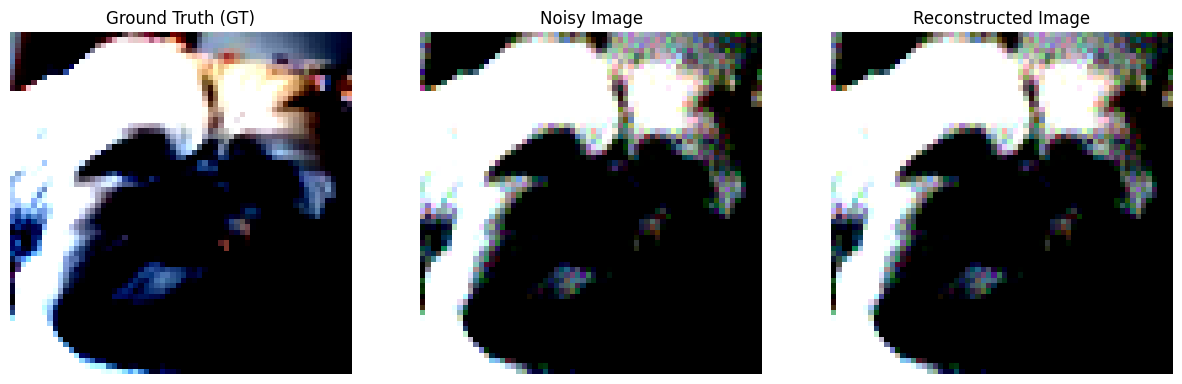

In [126]:
import matplotlib.pyplot as plt
import torch

# Denormalize function
def denormalize(tensor, mean, std):
    # Check the number of channels and denormalize accordingly
    if tensor.shape[1] == 3:  # RGB image
        for c in range(tensor.shape[1]):  # Loop over channels (C)
            tensor[:, c] = tensor[:, c] * std[c] + mean[c]
    elif tensor.shape[1] == 1:  # Grayscale image (1 channel)
        tensor[:, 0] = tensor[:, 0] * std[0] + mean[0]
    return tensor

# Select the first set of images (recons_x, gt, noisy) for visualization
recons_x, gt, noisy = saved_images[0]

# If the batch size is > 1, we need to select a single image from the batch
# Assuming we want to visualize the first image in the batch
recons_x = recons_x[0]  # Select the first image
gt = gt[0]              # Select the first image
noisy = noisy[0]        # Select the first image

# Denormalize the images
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

recons_x = denormalize(recons_x.clone(), mean, std)
gt = denormalize(gt.clone(), mean, std)
noisy = denormalize(noisy.clone(), mean, std)

# Convert tensors to numpy for plotting
recons_x_np = recons_x.squeeze().detach().cpu().permute(1, 2, 0).numpy()
gt_np = gt.squeeze().detach().cpu().permute(1, 2, 0).numpy()
noisy_np = noisy.squeeze().detach().cpu().permute(1, 2, 0).numpy()

# Plotting the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(gt_np)
axes[0].set_title('Ground Truth (GT)')
axes[0].axis('off')

axes[1].imshow(noisy_np)
axes[1].set_title('Noisy Image')
axes[1].axis('off')

axes[2].imshow(recons_x_np)
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')

plt.show()

# **finetuning smoothed tv**

In [139]:
import torch
import torch.nn as nn
from torch import autograd

def hoag_algorithm_with_finetuning(noisy_x, lambda0, x_star, labels, regu, 
                                   T_star, device, optimizer, max_iter=20, k=1.0, 
                                   epsilon=1e-6, kernel_size=5, num_kernels=2):
    
    # Define CrossEntropyLoss as the outer loss function
    outer_loss_fn = nn.CrossEntropyLoss().to(device)

    lambda0 = lambda0.to(device)
    tol = 0.0001  # Initial tolerance

    # Initialize RegularizerScaler
    regularizer = RegularizerScaler(regu=regu, kernel_size=kernel_size, num_kernels=num_kernels).to(device)
    
    # Step (i): Solve the inner optimization problem to get the initial gradient
    recons_x = inner_optimization(noisy_x, lambda0, x_star, regularizer=regularizer, 
                                   tol=tol).to(device)

    for iteration in range(max_iter):
        tol = max(tol * (1 - iteration / max_iter)**5, epsilon)  # Ensure tol does not go below epsilon

        # Step (i): Solve the inner optimization problem
        recons_x = inner_optimization(noisy_x, lambda0, x_star, 
                                       regularizer=regularizer, tol=tol).to(device)
        
        # Evaluate T_star to compute the outer loss
        T_star.eval()
        output = T_star(recons_x)
        outer_loss = outer_loss_fn(output, labels).to(device)  
        
        # Compute the gradient with respect to recons_x
        grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)        
        
        # Step (ii): Compute the Hessian-vector product
        new_inner_loss = inner_loss(noisy_x, x_star, lambda0, regularizer).to(device)
        Hxx = create_H_function(new_inner_loss, recons_x, recons_x)
        q_k = conjugate_gradient(Hxx, grad_g_x, tol=tol, max_iter=max_iter)
        hxlambda = compute_Hv(new_inner_loss, q_k, recons_x, lambda0, flag="hess").to(device)
        p_k = -hxlambda
        noisy_x = recons_x
    
    # Final evaluation
    T_star.eval()
    output = T_star(recons_x)
    outer_loss = outer_loss_fn(output, labels).to(device)    
    grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)
    p1 = torch.linalg.matrix_norm(grad_g_x).mean().item()
    L = k * p1
    
    return p_k, L, outer_loss, regularizer, tol

In [140]:
import torch
import torch.optim as optim
from torchvision.models import resnet50

# Load your ResNet-50 model
T_star_smtv = models.resnet50(pretrained=False) 
num_ftrs = T_star_smtv.fc.in_features
T_star_smtv.fc = nn.Linear(num_ftrs, len(train_data.classes))  # Adjust for the number of classes
T_star_smtv.load_state_dict(torch.load('/kaggle/input/stanford_dogs_resnet50/pytorch/default/1/resnet50_dog_model.pth'))
T_star_smtv = T_star_smtv.to(device)

# Freeze all parameters first
for param in T_star_smtv.parameters():
    param.requires_grad = False

# Unfreeze parameters in the fully connected (fc) layer
for param in T_star_smtv.fc.parameters():
    param.requires_grad = True

# Unfreeze parameters in layer4 (conv5 in your terminology)
for param in T_star_smtv.layer4.parameters():
    param.requires_grad = True

# Initialize the Adam optimizer for the trainable parameters
optimizer = optim.Adam(
    list(T_star_smtv.fc.parameters())+ list(T_star_smtv.layer4.parameters()),
    lr=0.00001
)

/tmp/ipykernel_105/722786877.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  T_star_smtv.load_state_dict(torch.load('/kaggle/input/stanford_dogs_resnet50/pytorch/default

In [141]:
import time
import copy
import torch
from tqdm import tqdm  # Import tqdm

# Initialize lambda0
lambda0 = 3*torch.ones(2, requires_grad=True, device=device)
regu = "smoothed_tv"
saved_images = []
# Loss function
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(5):  # Adjust epochs as needed
    # Training Phase
    train_start_time = time.time()
    
    # Initialize variables for loss tracking
    total_outer_loss = 0.0
    batch_count = 0

    # Add tqdm for the training phase
    train_loader = tqdm(blurred_train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)
    for (gt, noisy, labels) in train_loader:
        gt, noisy, labels = gt.to(device), noisy.to(device), labels.long().to(device)
        
        pk, L, loss, regularizer,tol = hoag_algorithm_with_finetuning(
            noisy_x=noisy, lambda0=lambda0, x_star=gt, optimizer=optimizer,
            labels=labels, regu=regu, 
            T_star=T_star_smtv, device=device, max_iter=3, k=1.0,
            epsilon=1e-4, kernel_size=5, num_kernels=2)

        # Update total outer loss
        total_outer_loss += loss.item()
        batch_count += 1

        # Update lambda0
#         if L * torch.linalg.vector_norm(pk) < 1:
#         print(L)
        L=1/L
        lambda0 = lambda0 - 0.01 * pk
        lambda0 = lambda0.clamp(min=-10, max=4)
        
        # Perform model training
        T_star_smtv.train()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print iteration details
        train_loader.set_postfix(lambda0=lambda0.data.cpu().numpy(), loss=loss.item(),tolerance=tol)

    train_end_time = time.time()
    train_elapsed_time = train_end_time - train_start_time

    # Calculate average loss for the epoch
    average_loss = total_outer_loss / batch_count if batch_count > 0 else 0.0
    print(f"Average loss: {average_loss}, Epoch: {epoch}")    

Average loss: 2.3209204058628528, Epoch: 0


Average loss: 3.7993839543312786, Epoch: 1


Average loss: 3.0378214955329894, Epoch: 2


Average loss: 1.6177144854019085, Epoch: 3


Average loss: 0.5609872522453467, Epoch: 4


In [144]:
from tqdm import tqdm
import time

# Evaluation Phase
outer_loss = 0.0
correct_predictions = 0
total_samples = 0
T_star_smtv.eval()

eval_start_time = time.time()
saved_images = []  # Initialize saved images list

# Wrap the test loader with tqdm for a progress bar
with torch.no_grad():
    progress_bar = tqdm(blurred_test_loader, desc="Evaluating", unit="batch")
    for (gt, noisy, labels) in progress_bar:
        gt, noisy, labels = gt.to(device), noisy.to(device), labels.to(device)
        noisy_copy = copy.deepcopy(noisy)

        # Solve inner optimization problem
        recons_x = inner_optimization(noisy_x=noisy, lambda0=lambda0, x_star=gt, 
                                      tol=1e-4, regularizer=regularizer)
        saved_images.append((recons_x.cpu(), gt.cpu(), noisy_copy.cpu()))

        # Predict using T_star
        output = T_star_smtv(recons_x)

        # Compute the loss
        loss = criterion(output, labels)
        outer_loss += loss.item() * labels.size(0)  # Multiply by batch size for correct averaging

        # Compute accuracy
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Update running accuracy and loss in progress bar
        running_accuracy = correct_predictions / total_samples * 100  # Running accuracy as percentage
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{running_accuracy:.2f}%")

eval_end_time = time.time()
eval_elapsed_time = eval_end_time - eval_start_time
                
# Calculate final metrics
average_loss = outer_loss / len(blurred_test_loader.dataset)  # Normalize by number of samples
accuracy = correct_predictions / total_samples * 100  # Accuracy as a percentage

# Print results
print(f"Epoch {epoch + 1}")
print(f"Training Time: {train_elapsed_time:.2f}s")
print(f"Evaluation Time: {eval_elapsed_time:.2f}s")
print(f"Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

Evaluating:   2%|▏         | 11/500 [00:15<11:19,  1.39s/batch, acc=0.00%, loss=4.2787]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import torch

# Denormalize function
def denormalize(tensor, mean, std):
    # Check the number of channels and denormalize accordingly
    if tensor.shape[1] == 3:  # RGB image
        for c in range(tensor.shape[1]):  # Loop over channels (C)
            tensor[:, c] = tensor[:, c] * std[c] + mean[c]
    elif tensor.shape[1] == 1:  # Grayscale image (1 channel)
        tensor[:, 0] = tensor[:, 0] * std[0] + mean[0]
    return tensor

# Select the first set of images (recons_x, gt, noisy) for visualization
recons_x, gt, noisy = saved_images[0]

# If the batch size is > 1, we need to select a single image from the batch
# Assuming we want to visualize the first image in the batch
recons_x = recons_x[0]  # Select the first image
gt = gt[0]              # Select the first image
noisy = noisy[0]        # Select the first image

# Denormalize the images
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

recons_x = denormalize(recons_x.clone(), mean, std)
gt = denormalize(gt.clone(), mean, std)
noisy = denormalize(noisy.clone(), mean, std)

# Convert tensors to numpy for plotting
recons_x_np = recons_x.squeeze().detach().cpu().permute(1, 2, 0).numpy()
gt_np = gt.squeeze().detach().cpu().permute(1, 2, 0).numpy()
noisy_np = noisy.squeeze().detach().cpu().permute(1, 2, 0).numpy()

# Plotting the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(gt_np)
axes[0].set_title('Ground Truth (GT)')
axes[0].axis('off')

axes[1].imshow(noisy_np)
axes[1].set_title('Noisy Image')
axes[1].axis('off')

axes[2].imshow(recons_x_np)
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')

plt.show()